In [16]:
import os
import configparser
import geopandas as gpd
from shapely.geometry import Point, Polygon

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [3]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]


In [42]:
GHS_POP = gpd.read_parquet(os.path.join(gdata_root,'GHLS','GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R3_C20.parquet')).to_crs('EPSG:25833')
#value is pop density in dwellers/hectare
GHS_POP.VALUE = GHS_POP.VALUE.astype(float)

In [96]:
GHS_POP.iloc[1334].geometry.area    

10012.140310801544

In [46]:
GHS_POP.head()

,VALUE,geometry
0,1.408518,"MULTIPOLYGON (((397197.657 5837259.270, 397188..."
1,0.000000,"MULTIPOLYGON (((396912.048 5837191.146, 396877..."
2,0.000000,"MULTIPOLYGON (((396951.332 5837183.238, 396950..."
3,0.000000,"MULTIPOLYGON (((397136.268 5837189.054, 397095..."
4,0.000000,"MULTIPOLYGON (((397188.831 5837249.175, 397136..."


In [5]:
Einwohnerdichte=gpd.GeoDataFrame.from_file(os.path.join(gdata_root,'Berlin','Einwohnerdichte 2022 (Umweltatlas).gpkg'), crs ='EPSG:25833')
#ew_ha_2022 is is pop density in dwellers/hectare

In [22]:
Einwohnerdichte.head()

,schl5,ew2022,flalle,ew_ha_2022,alter_u6,alter_6_u10,alter_10_u18,alter_18_u65,alter_65_u70,alter_70_u75,alter75_u80,alter_80plus,typklar,geometry
0,0100980011000100,0,4623.972334,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Freie Zeilenbebauung mit landschaftlichem Sied...,"MULTIPOLYGON (((389424.849 5821759.519, 389373..."
1,0100980011000200,0,13430.943579,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parkplatz,"MULTIPOLYGON (((389424.849 5821759.519, 389336..."
2,0100980011000300,18,5603.764396,32.12,0.0,0.0,3.0,12.0,3.0,0.0,0.0,0.0,Geschosswohnungsbau der 1990er Jahre und jünger,"MULTIPOLYGON (((389326.319 5821907.843, 389287..."
3,0100980021000200,850,34344.728410,247.49,56.0,34.0,48.0,629.0,24.0,22.0,16.0,21.0,"Heterogene, innerstädtische Mischbebauung, Lüc...","MULTIPOLYGON (((389743.255 5822026.125, 389703..."
4,0100980021000300,3,48930.211209,0.61,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,Krankenhaus,"MULTIPOLYGON (((389693.578 5821875.268, 389605..."


Check Berlin population in both datasets

In [6]:
Einwohnerdichte.ew2022.sum()

3850657

In [7]:
GHS_POP.VALUE.sum()

Decimal('3603689.63558145')

In [8]:
Einwohnerdichte.flalle.describe()

count    2.639700e+04
mean     3.007410e+04
std      6.382849e+04
min      3.532505e+01
25%      9.775718e+03
50%      1.738056e+04
75%      3.013134e+04
max      4.233009e+06
Name: flalle, dtype: float64

the Einwohnerdichte polygons are larger than 1 hectare on average, so GHS_POP could be more precise in terms of spatial resoluion.
let us check how much these two datasets disagree

In [18]:
GHS_POP['Einwohnerdichte']=np.nan

In [45]:
def calc_Einwohnerdichte(row):
    result = 0
    # find overlapping polygons
    t=row.geometry.overlaps(Einwohnerdichte.geometry)
    ind=t[t].index
    #for each polygon estimate pop: multiply Einwohnerdichte polygon with the fraction of area it covers in GHS_POP
    for i in ind:
        result = result + row.geometry.intersection(Einwohnerdichte.iloc[i].geometry).area/row.geometry.area * Einwohnerdichte.iloc[i].ew_ha_2022
    return result
    

In [48]:
GHS_POP['Einwohnerdichte']=GHS_POP.apply(calc_Einwohnerdichte, axis=1)

In [86]:
GHS_POP['VALUE']=GHS_POP['VALUE'].mask(GHS_POP['VALUE'].abs()<1E-2,0)
GHS_POP['Einwohnerdichte']=GHS_POP['Einwohnerdichte'].mask(GHS_POP['Einwohnerdichte'].abs()<1E-2,0)

In [87]:
GHS_POP['ratio']=GHS_POP['VALUE']/GHS_POP['Einwohnerdichte']
GHS_POP.replace([np.inf, -np.inf], np.nan, inplace=True)

<Axes: >

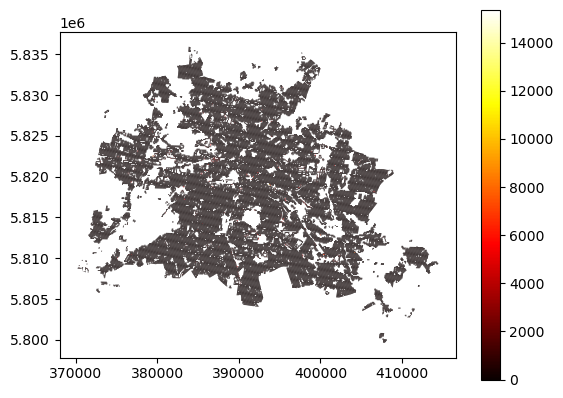

In [91]:
GHS_POP.plot('ratio', cmap='hot', legend=True)

In [32]:
GHS_POP.iloc[10003].geometry.intersection(Einwohnerdichte.iloc[18866].geometry).area/GHS_POP.iloc[10003].geometry.area * Einwohnerdichte.iloc[18866].ew_ha_2022

139.02937046697016

In [90]:
GHS_POP['ratio'].describe()

count    52279.000000
mean        19.844941
std        192.064194
min          0.000000
25%          0.622857
50%          1.229040
75%          2.545763
max      15359.382940
Name: ratio, dtype: float64

In [88]:
GHS_POP['ratio'].idxmax()

82067

In [89]:
GHS_POP.iloc[GHS_POP['ratio'].idxmax()].Einwohnerdichte                                                  

0.01030160446272555